In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

from visualization_utils import *

# Model Performance Analysis

In [2]:
# Get the log files of MNIST dataset
log_files = get_logs('mnist', 'mnist/stat')
log_files

['mnist/stat_metrics-B-10-E-1.csv',
 'mnist/stat_metrics-B-10-E-5.csv',
 'mnist/stat_metrics-B-50-E-1.csv',
 'mnist/stat_metrics-B-50-E-5.csv',
 'mnist/stat_metrics-B-600-E-1.csv',
 'mnist/stat_metrics-B-600-E-5.csv']

### Increasing computation

In [3]:
# Get test accuracy trend of different hyperparameter settings
accuracies_B10_E1 = get_accuracy(log_files[0]).tolist()
accuracies_B10_E5 = get_accuracy(log_files[1]).tolist()
accuracies_B50_E1 = get_accuracy(log_files[2]).tolist()
accuracies_B50_E5 = get_accuracy(log_files[3]).tolist()
accuracies_B600_E1 = get_accuracy(log_files[4]).tolist()
accuracies_B600_E5 = get_accuracy(log_files[5]).tolist()

In [4]:
# Change evaluation interval
accuracies_B10_E1 = change_evaluation_interval(accuracies_B10_E1, 20)
accuracies_B10_E5 = change_evaluation_interval(accuracies_B10_E5, 20)
accuracies_B50_E1 = change_evaluation_interval(accuracies_B50_E1, 20)
accuracies_B50_E5 = change_evaluation_interval(accuracies_B50_E5, 20)
accuracies_B600_E1 = change_evaluation_interval(accuracies_B600_E1, 20)
accuracies_B600_E5 = change_evaluation_interval(accuracies_B600_E5, 20)

In [5]:
# Find total number of communcation needed to achieve the target accuracy
#next(x[0] for x in enumerate(accuracies_B600_E1) if x[1] >= 0.7) + 1
print(next(x[0] for x in enumerate(accuracies_B600_E5) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_B50_E1) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_B10_E1) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_B50_E5) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_B10_E5) if x[1] >= 0.7) + 1)

30
15
13
9
6


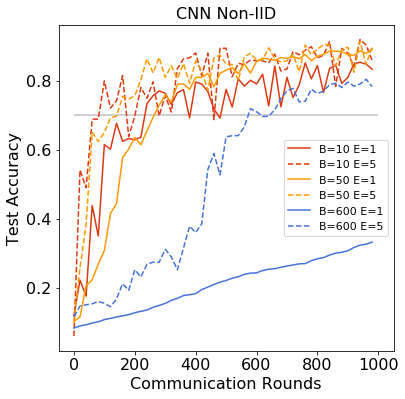

In [6]:
# Plot the test accuracy over communcation rounds
plt.figure(figsize=(6, 6))
plt.title('CNN Non-IID', fontsize=16)
plt.plot(accuracies_B10_E1, label='B=10 E=1', c='#dc3912')
plt.plot(accuracies_B10_E5, label='B=10 E=5', c='#dc3912', ls='--')
plt.plot(accuracies_B50_E1, label='B=50 E=1', c='#ff9900')
plt.plot(accuracies_B50_E5, label='B=50 E=5', c='#ff9900', ls='--')
plt.plot(accuracies_B600_E1, label='B=600 E=1', c='#4272db')
plt.plot(accuracies_B600_E5, label='B=600 E=5', c='#4272db', ls='--')
plt.hlines(0.7, 0, 50, colors='gray', alpha=0.5)
plt.xticks(np.arange(0, 51, 10), ('0', '200', '400', '600', '800', '1000'), fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Communication Rounds", fontsize=16)
plt.ylabel("Test Accuracy", fontsize=16)
plt.legend(fontsize=11);

### Increasing parallelism

In [7]:
# Get the log files of MNIST dataset
log_files = get_logs('2nn', '2nn/stat')
log_files

['2nn/stat_metrics-C-00.csv',
 '2nn/stat_metrics-C-01.csv',
 '2nn/stat_metrics-C-02.csv',
 '2nn/stat_metrics-C-05.csv']

In [8]:
# Get test accuracy trend of different hyperparameter settings
accuracies_C00 = get_accuracy(log_files[0]).tolist()
accuracies_C01 = get_accuracy(log_files[1]).tolist()
accuracies_C02 = get_accuracy(log_files[2]).tolist()
accuracies_C05 = get_accuracy(log_files[3]).tolist()

In [9]:
# Change evaluation interval
accuracies_C00 = change_evaluation_interval(accuracies_C00, 20)
accuracies_C01 = change_evaluation_interval(accuracies_C01, 20)
accuracies_C02 = change_evaluation_interval(accuracies_C02, 20)
accuracies_C05 = change_evaluation_interval(accuracies_C05, 20)

In [10]:
# Find total number of communcation needed to achieve the target accuracy
#next(x[0] for x in enumerate(accuracies_B600_E1) if x[1] >= 0.7) + 1
print(next(x[0] for x in enumerate(accuracies_C00) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_C01) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_C02) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_C05) if x[1] >= 0.7) + 1)

11
7
6
6


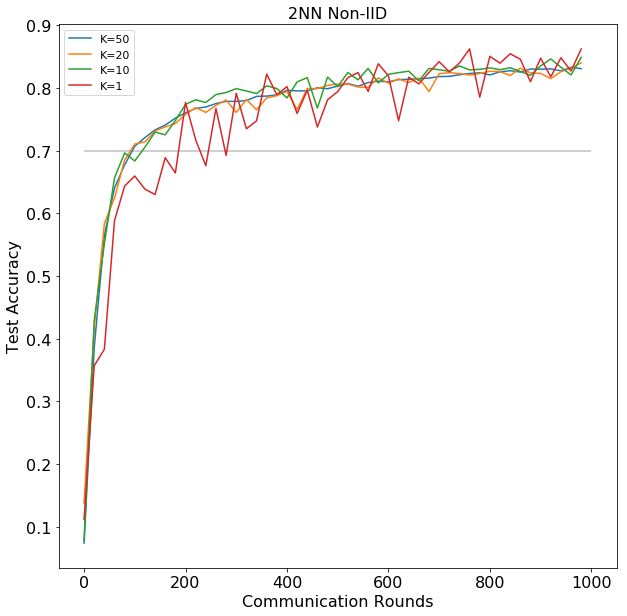

In [11]:
# Plot the test accuracy over communcation rounds
plt.figure(figsize=(10, 10))
plt.title('2NN Non-IID', fontsize=16)
plt.plot(accuracies_C05, label='K=50')
plt.plot(accuracies_C02, label='K=20')
plt.plot(accuracies_C01, label='K=10')
plt.plot(accuracies_C00, label='K=1')
plt.hlines(0.7, 0, 50, colors='gray', alpha=0.5)
plt.xticks(np.arange(0, 51, 10), ('0', '200', '400', '600', '800', '1000'), fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Communication Rounds", fontsize=16)
plt.ylabel("Test Accuracy", fontsize=16)
plt.legend(fontsize=11);

# Communcation Cost Analysis

In [12]:
# Get the log files of MNIST dataset
log_files = get_logs('2nn', '2nn/sys')
log_files

['2nn/sys_metrics-C-00.csv',
 '2nn/sys_metrics-C-01.csv',
 '2nn/sys_metrics-C-02.csv',
 '2nn/sys_metrics-C-05.csv']

In [13]:
# Get bytes send trend of different hyperparameter settings
bytes_C00 = get_bytes(log_files[0])
bytes_C01 = get_bytes(log_files[1])
bytes_C02 = get_bytes(log_files[2])
bytes_C05 = get_bytes(log_files[3])

In [14]:
# Configuration
rounds = get_bytes(log_files[0]).index.values
figsize = (10, 8)
title_fontsize = 16

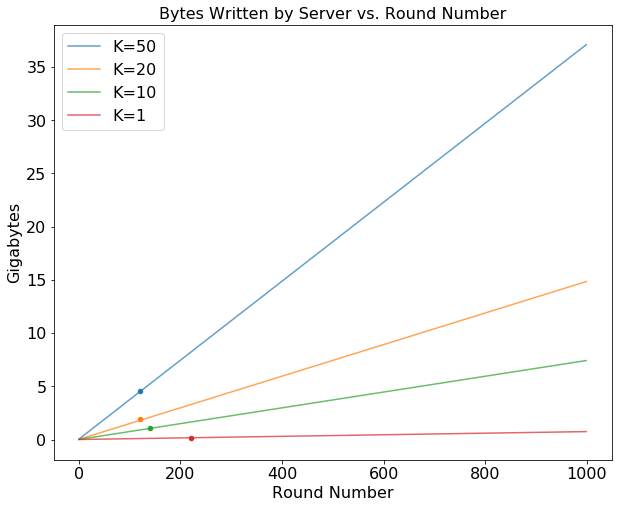

In [15]:
plt.figure(figsize=figsize)

plt.plot(rounds, bytes_C05['bytes_written'], label='K=50', alpha=0.7)
plt.plot(rounds, bytes_C02['bytes_written'], label='K=20', alpha=0.7)
plt.plot(rounds, bytes_C01['bytes_written'], label='K=10', alpha=0.7)
plt.plot(rounds, bytes_C00['bytes_written'], label='K=1', alpha=0.7)

plt.scatter(20*6, 4.6, s=20)
plt.scatter(20*6, 1.9, s=20)
plt.scatter(20*7, 1.1, s=20)
plt.scatter(20*11, 0.16, s=20)

plt.title('Bytes Written by Server vs. Round Number', fontsize=title_fontsize)
plt.xlabel('Round Number', fontsize=title_fontsize)
plt.ylabel('Gigabytes', fontsize=title_fontsize)
plt.xticks(fontsize=title_fontsize)
plt.yticks(fontsize=title_fontsize)
plt.legend(fontsize=title_fontsize)
plt.show()

In [16]:
print(bytes_C05.loc[6*20, 'bytes_written'])
print(bytes_C02.loc[6*20, 'bytes_written'])
print(bytes_C01.loc[7*20, 'bytes_written'])
print(bytes_C00.loc[11*20, 'bytes_written'])

4.489796236157417
1.795918494462967
1.046382263302803
0.16400743275880814
